In [1]:
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn


from utils_ocr.ctc_decoder import ctc_decode

torch.backends.cudnn.enabled = False

In [2]:
epochs = 10000
batch_size = 32
lr = 0.0005
show_interval = 10
valid_interval = 500
save_interval = 2000
cpu_workers = 4
reload_checkpoint = None
valid_max_iter = 100

img_width = 100
img_height = 32
data_dir = '/home/vankhoa/datasets/mjsynth/mnt/ramdisk/max/90kDICT32px/'
checkpoints_dir = 'utils_ocr/checkpoints/'
reload_checkpoint = 'utils_ocr/checkpoints/crnn_synth90k.pt'
images = 'utils_ocr/demo/78_Novel_52433.jpg'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


In [3]:
paths = glob.glob('utils_ocr/demo/*.jpg')
print(paths)

['utils_ocr/demo/170_READING_62745.jpg', 'utils_ocr/demo/178_Showtime_70541.jpg', 'utils_ocr/demo/78_Novel_52433.jpg']


In [4]:
class Synth90kDataset(Dataset):
    CHARS = '0123456789abcdefghijklmnopqrstuvwxyz'
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

    def __init__(self, paths=None, img_height=32, img_width=100):
        self.paths = paths
        self.img_height = img_height
        self.img_width = img_width

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]

        try:
            image = Image.open(path).convert('L')  # grey-scale
        except IOError:
            print('Corrupted image for %d' % index)
            return self[index + 1]

        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)
        image = image.reshape((1, self.img_height, self.img_width))
        image = (image / 127.5) - 1.0

        image = torch.FloatTensor(image)

        return image


def synth90k_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths

In [5]:
predict_dataset = Synth90kDataset(paths=paths, img_height=img_height, img_width=img_width)

predict_loader = DataLoader(
    dataset=predict_dataset,
    batch_size=batch_size,
    shuffle=False)

In [6]:

class CRNN(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNN, self).__init__()

        self.cnn, (output_channel, output_height, output_width) = \
            self._cnn_backbone(img_channel, img_height, img_width, leaky_relu)

        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def _cnn_backbone(self, img_channel, img_height, img_width, leaky_relu):
        assert img_height % 16 == 0
        assert img_width % 4 == 0

        channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
        kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
        strides = [1, 1, 1, 1, 1, 1, 1]
        paddings = [1, 1, 1, 1, 1, 1, 0]

        cnn = nn.Sequential()

        def conv_relu(i, batch_norm=False):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(
                f'conv{i}',
                nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
            )

            if batch_norm:
                cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
            cnn.add_module(f'relu{i}', relu)

        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        conv_relu(0)
        cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
        # (64, img_height // 2, img_width // 2)

        conv_relu(1)
        cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
        # (128, img_height // 4, img_width // 4)

        conv_relu(2)
        conv_relu(3)
        cnn.add_module(
            'pooling2',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (256, img_height // 8, img_width // 4)

        conv_relu(4, batch_norm=True)
        conv_relu(5, batch_norm=True)
        cnn.add_module(
            'pooling3',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (512, img_height // 16, img_width // 4)

        conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

        output_channel, output_height, output_width = \
            channels[-1], img_height // 16 - 1, img_width // 4 - 1
        return cnn, (output_channel, output_height, output_width)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.cnn(images)
        batch, channel, height, width = conv.size()

        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)


In [7]:
num_class = len(Synth90kDataset.LABEL2CHAR) + 1
crnn = CRNN(1, img_height, img_width, num_class,
            map_to_seq_hidden=64,
            rnn_hidden=256,
            leaky_relu=False)
crnn.load_state_dict(torch.load(reload_checkpoint, map_location=device))
crnn.to(device)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (conv5): Conv2d(512, 512, 

In [8]:
def predict(crnn, dataloader, label2char, decode_method, beam_size):
    crnn.eval()
    pbar = tqdm(total=len(dataloader), desc="Predict")

    all_preds = []
    with torch.no_grad():
        for data in dataloader:
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images = data.to(device)

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            preds = ctc_decode(log_probs, method=decode_method, beam_size=beam_size,
                               label2char=label2char)
            all_preds += preds

            pbar.update(1)
        pbar.close()

    return all_preds

In [9]:
def show_result(paths, preds):
    print('\n===== result =====')
    for path, pred in zip(paths, preds):
        img = plt.imread(path)
        fig, ax = plt.subplots()
        im = ax.imshow(img)
        plt.show()
        text = ''.join(pred)
        print(f'{path} > {text}')

In [10]:
preds = predict(crnn, predict_loader, Synth90kDataset.LABEL2CHAR,
                    decode_method='beam_search',
                    beam_size=10)

Predict: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]



===== result =====


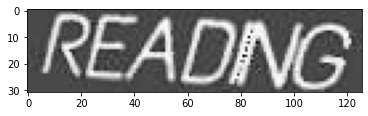

utils_ocr/demo/170_READING_62745.jpg > reading


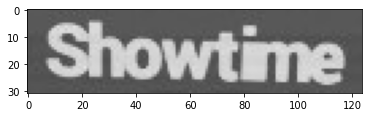

utils_ocr/demo/178_Showtime_70541.jpg > showtime


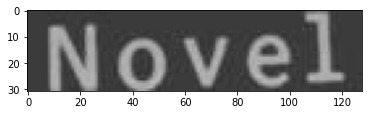

utils_ocr/demo/78_Novel_52433.jpg > novel


In [11]:
show_result(paths, preds)